# Feedback Prize - Evaluating Student Writing

The following EDA Jupyter Notebook is based on the work done by [Rob Mulla](https://www.kaggle.com/robikscube) ([🎓 Student Writing Competition [Twitch Stream]](https://www.kaggle.com/robikscube/student-writing-competition-twitch-stream/notebook?scriptVersionId=83303421)) and [Erik Bruin](https://www.kaggle.com/erikbruin) ([NLP on Student Writing: EDA](https://www.kaggle.com/erikbruin/nlp-on-student-writing-eda)). 

If the code below was helpful in any way to you, make sure to review and upvote the original code on their Kaggle posts

In [1]:
"""
Changing working directory to repository path 
in order to make simpler references to files/folder.

Also, adding src folder in the repository to import
any code that has been moved to py files for reusability
"""

import os
REPOSITORY_PATH = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlgpu2/code/Users/santiago.a.diez/evaluating-student-writing-kaggle-challenge'
os.chdir(REPOSITORY_PATH)
import sys  
sys.path.insert(0, 'src')

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import spacy

from eswkg.config import Config

In [8]:
train = pd.read_csv(Config.get_file_path(config_key="train"))
train[['discourse_id', 'discourse_start', 'discourse_end']] = train[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)

sample_submission = pd.read_csv(Config.get_file_path(config_key="sample_submission"))

#The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
train_txt = glob(Config.get_file_path(config_key="train_folder") + "/*.txt") 
test_txt = glob(Config.get_file_path(config_key="test_folder") + "/*.txt")

# Introduction to the competition

Basically, we have a bunch of essays written by kids in the age range of about 12-18 years old in which we have to find word sequences that can be classified as one of 7 "discourse types". These are:

- Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
- Position - an opinion or conclusion on the main question
- Claim - a claim that supports the position
- Counterclaim - a claim that refutes another claim or gives an opposing reason to the position
- Rebuttal - a claim that refutes a counterclaim
- Evidence - ideas or examples that support claims, counterclaims, or rebuttals.
- Concluding Statement - a concluding statement that restates the claims

Let's look at the full text of one essay first.

'F7149C7BC3B3.txt'

In [30]:
from random import randint

essay_index = randint(0,len(train_txt)-1)
essay_path = train_txt[random_index]
essay_id = os.path.basename(essay_path).rsplit(".",1)[0]

print(f"- Essay index: {essay_index}")
print(f"- Essay name: {essay_id}","\n")
!cat $essay_path

- Essay index: 14808
- Essay name: F7149C7BC3B3 

First, Face is just a natural landform because even if it was created by alians there should be some type of building or something some where a round the Face like a building. Think about it. Do you really think that some alian is going to build something like that and leave it there? There is so much things we don't know about Mars, but aliens are not real. According to the text,"Meanwhile, defenders of the NASA budget wish there was an ancient civilization on Mars."

Second, when we took a picture of the Face in 1976. It was because of the weather that it looked like a face. Another reason is because of the angle that we took a picture in. It might also have been the camera. Because of the angle that in took the picture in, the shadow of the mountains made it look like a face. According to the text,"The caotion noted a "huge rock formation...which resembles a human head...formed by shadows giving illusion of eyes,nose,and mouth."

Nex

The train dataset gives us the following human annotations that are extracted from this essay.

In [34]:
train.query(f'id == "{essay_id}"')

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
57050,F7149C7BC3B3,1618345049269,7,38,Face is just a natural landform,Position,Position 1,1 2 3 4 5 6
57051,F7149C7BC3B3,1618345055211,47,175,even if it was created by alians there should ...,Claim,Claim 1,8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ...
57052,F7149C7BC3B3,1618337188521,176,473,Think about it. Do you really think that some ...,Evidence,Evidence 1,33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4...
57053,F7149C7BC3B3,1618337200050,474,582,"Second, when we took a picture of the Face in ...",Claim,Claim 2,86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 ...
57054,F7149C7BC3B3,1618337204630,583,946,Another reason is because of the angle that w...,Evidence,Evidence 2,109 110 111 112 113 114 115 116 117 118 119 12...
57055,F7149C7BC3B3,1618337218966,947,1185,"Next, in 1998, we decided to take another pict...",Evidence,Evidence 3,171 172 173 174 175 176 177 178 179 180 181 18...
57056,F7149C7BC3B3,1618337226447,1186,1214,It wasn't a face after all.,Claim,Claim 3,220 221 222 223 224 225
57057,F7149C7BC3B3,1618337237685,1215,1637,"Then, in 2001, we took another picture because...",Evidence,Evidence 4,226 227 228 229 230 231 232 233 234 235 236 23...
57058,F7149C7BC3B3,1618337243356,1637,1752,We have been searching Mars for a while now an...,Claim,Claim 4,294 295 296 297 298 299 300 301 302 303 304 30...
57059,F7149C7BC3B3,1618337250460,1753,2062,"Finally, Face is just another natural land for...",Concluding Statement,Concluding Statement 1,318 319 320 321 322 323 324 325 326 327 328 32...


Kaggle gives us the following field descriptions:
- id - ID code for essay response
- discourse_id - ID code for discourse element
- discourse_start - character position where discourse element begins in the essay response
- discourse_end - character position where discourse element ends in the essay response
- discourse_text - text of discourse element
- discourse_type - classification of discourse element
- discourse_type_num - enumerated class label of discourse element
- predictionstring - the word indices of the training sample, as required for predictions

The Ground Truth here is a combination of the discourse type and the prediction string. The predictionstring corresponds to the index of the words in the essay and the predicted discourse type for this sequence of words should be correct. There can be partial matches, if the correct discourse type is predicted but on a longer or shorter sequence of words than specified in the Ground Truth.

As we can see, not necessarily all text of an essay is part of a discourse. In this case, the title is not part of any discourse.


# Lenght of the discourse_text and predictionstring
First, I would like to check if the discourse_text and the predictionstring always have the same number of words (as they should).

In [5]:
#add columns
train["discourse_len"] = train["discourse_text"].apply(lambda x: len(x.split()))
train["pred_len"] = train["predictionstring"].apply(lambda x: len(x.split()))


cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len']
train[cols_to_display].head()

,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
0,1622627660524,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,44,44
1,1622627653021,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,15,15
2,1622627671020,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,16,16
3,1622627696365,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,63,63
4,1622627759780,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...,24,24


Is this always correct? No, I find 468 discourses where this goes wrong (by one word)

In [6]:
print(f"The total number of discourses is {len(train)}")
train.query('discourse_len != pred_len')[cols_to_display]

The total number of discourses is 144293


,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
107,1622473475289,if we would just make stricker laws for phone ...,Concluding Statement,303 304 305 306 307 308 309 310 311 312 313 31...,19,18
1025,1622564912260,for navigation to wherever they are going,Claim,105 106 107 108 109 110 111 112,7,8
1525,1622992466917,People should not be able to use cell phones w...,Position,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,47,48
1526,1622992280991,"First, cell phones are a benefit and allows ev...",Claim,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 8...,21,22
1527,1622992426147,"Kids, teenagers, adults, even grandparents hav...",Evidence,90 91 92 93 94 95 96 97 98 99 100 101 102 103 ...,78,79
...,...,...,...,...,...,...
142607,1617826841342,seeking people's opinions on making a choice i...,Concluding Statement,563 564 565 566 567 568 569 570 571 572 573 57...,51,50
143191,1617887956153,i feel like for the bst advice ask more then o...,Evidence,185 186 187 188 189 190 191 192 193 194 195 19...,83,82
143227,1617652582742,", asking for advice from multiple people will ...",Concluding Statement,467 468 469 470 471 472 473 474 475 476 477 47...,84,83
143311,1618286838241,Seeking multiple opinions can help make a bett...,Claim,159 160 161 162 163 164 165 166 167 168 169 17...,15,16


Let's check the first one.

In [7]:
print(train.query('discourse_id == 1622473475289')['discourse_text'].values[0])
print(train.query('discourse_id == 1622473475289')['discourse_text'].values[0].split())
print(len(train.query('discourse_id == 1622473475289')['discourse_text'].values[0].split()))

if we would just make stricker laws for phone an driving the people would stop because of the consequences.      
['if', 'we', 'would', 'just', 'make', 'stricker', 'laws', 'for', 'phone', 'an', 'driving', 'the', 'people', 'would', 'stop', 'because', 'of', 'the', 'consequences.']
19


The length of 19 words seems correct to me, and the length of the predictionstring also really seems to be 18. Something to keep in mind.

In [8]:
print(train.query('discourse_id == 1622473475289')['predictionstring'].values[0])
print(train.query('discourse_id == 1622473475289')['predictionstring'].values[0].split())
print(len(train.query('discourse_id == 1622473475289')['predictionstring'].values[0].split()))

303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
['303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320']
18


# Length and frequency and releative position per discourse_type

Is there a correlation between the length of a discourse and the class (discourse_type)? Yes, there is. Evidence is the longest discount type on average. When looking at the frequencies of occurence, we see that Counterclaim and Rebuttal are relatively rare

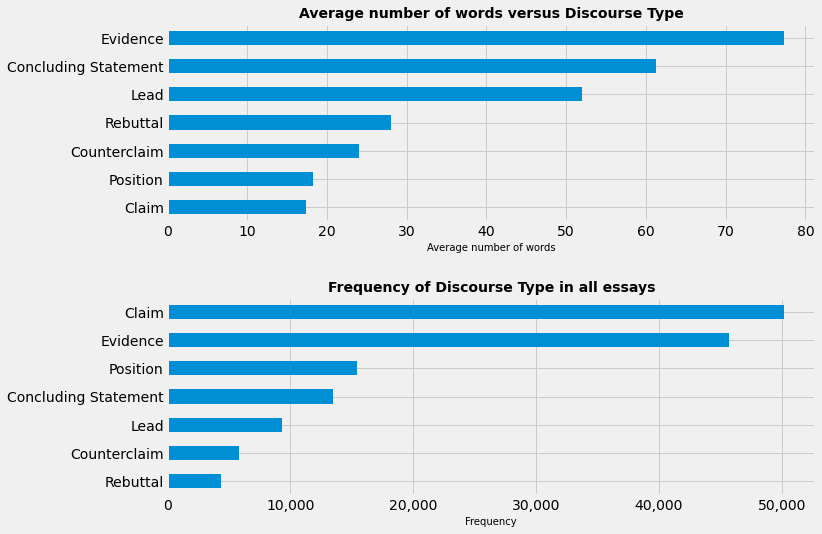

In [9]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1 = train.groupby('discourse_type')['discourse_len'].mean().sort_values().plot(kind="barh")
ax1.set_title("Average number of words versus Discourse Type", fontsize=14, fontweight = 'bold')
ax1.set_xlabel("Average number of words", fontsize = 10)
ax1.set_ylabel("")

ax2 = fig.add_subplot(212)
ax2 = train.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind="barh")
ax2.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
ax2.set_title("Frequency of Discourse Type in all essays", fontsize=14, fontweight = 'bold')
ax2.set_xlabel("Frequency", fontsize = 10)
ax2.set_ylabel("")

plt.tight_layout(pad=2)
plt.show()

We do have the field discourse_type_num. We see that Evidence1, Position1 and Claim1 are almost always there in an essay. Most students also had at least one Concluding Statement. What's surprising to me is that a Lead is missing in about 40% of the essays (Lead 1 is found in almost 60% of the essays).

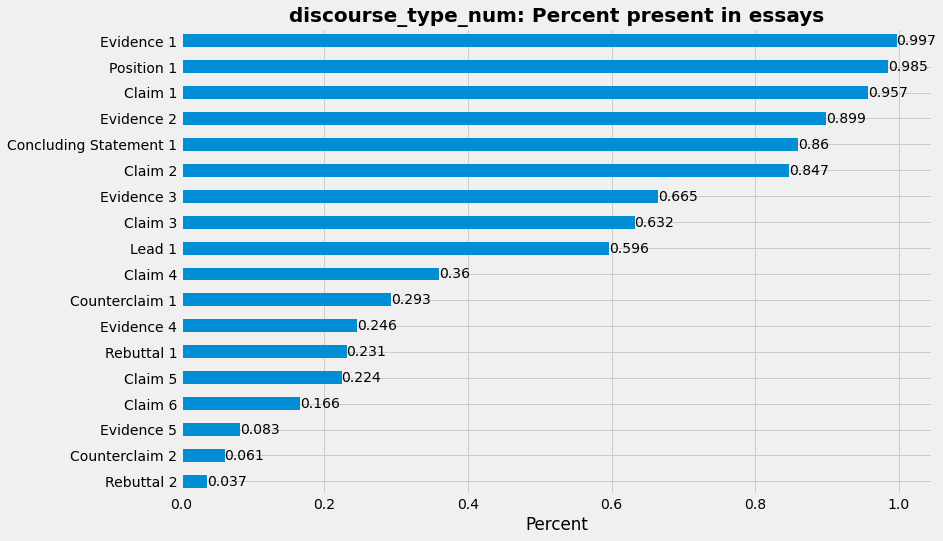

In [10]:
fig = plt.figure(figsize=(12,8))
av_per_essay = train['discourse_type_num'].value_counts(ascending = True).rename_axis('discourse_type_num').reset_index(name='count')
av_per_essay['perc'] = round((av_per_essay['count'] / train.id.nunique()),3)
av_per_essay = av_per_essay.set_index('discourse_type_num')
ax = av_per_essay.query('perc > 0.03')['perc'].plot(kind="barh")
ax.set_title("discourse_type_num: Percent present in essays", fontsize=20, fontweight = 'bold')
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_xlabel("Percent")
ax.set_ylabel("")
plt.show()

However, I am also interested in the relative positions of discourse types with the essays. Therefore, I am adding this number in the loop below. I think the main takeaway is that the Lead (if it's there!) is almost always the first discourse in an essay.

**More on this in the next version.**

In [11]:
train['discourse_nr'] = 1
counter = 1

for i in tqdm(range(1, len(train))):
    if train.loc[i, 'id'] == train.loc[i-1, 'id']:
        counter += 1
        train.loc[i, 'discourse_nr'] = counter
    else:
        counter = 1
        train.loc[i, 'discourse_nr'] = counter
        
av_position = train.groupby('discourse_type')['discourse_nr'].mean().sort_values()
av_position

  0%|          | 0/144292 [00:00<?, ?it/s]

discourse_type
Lead                    1.004514
Position                2.201116
Claim                   5.163480
Evidence                6.627478
Counterclaim            7.304968
Rebuttal                8.684344
Concluding Statement    9.644650
Name: discourse_nr, dtype: float64

# Investigation the gaps between Annotations (text not used as discourse_text)

Just taking the last discourse_end in train is not entirely correct as a last piece of text may not have been used as a discourse. Therefore, I will go through the essays to find the real ends. Eh....until I remebered that Rob Mulla already did that in the excellent EDA (https://www.kaggle.com/robikscube/student-writing-competition-twitch) ;-). Please upvote his notebook!

In [12]:
# this code chunk is copied from Rob Mulla
len_dict = {}
word_dict = {}
for t in tqdm(train_txt):
    with open(t, "r") as txt_file:
        myid = t.split("/")[-1].replace(".txt", "")
        data = txt_file.read()
        mylen = len(data.strip())
        myword = len(data.split())
        len_dict[myid] = mylen
        word_dict[myid] = myword
train["essay_len"] = train["id"].map(len_dict)
train["essay_words"] = train["id"].map(word_dict)

  0%|          | 0/15594 [00:00<?, ?it/s]

When comparing the discourse_end of the last discourse in each essay, we see that the discourse_end is sometimes larger than the essay_len. This cannot be right, but I will assume that those are last pieces of text in the essay indeed.

In [13]:
#initialize column
train['gap_length'] = np.nan

#set the first one
train.loc[0, 'gap_length'] = 7 #discourse start - 1 (previous end is always -1)

#loop over rest
for i in tqdm(range(1, len(train))):
    #gap if difference is not 1 within an essay
    if ((train.loc[i, "id"] == train.loc[i-1, "id"])\
        and (train.loc[i, "discourse_start"] - train.loc[i-1, "discourse_end"] > 1)):
        train.loc[i, 'gap_length'] = train.loc[i, "discourse_start"] - train.loc[i-1, "discourse_end"] - 2
        #minus 2 as the previous end is always -1 and the previous start always +1
    #gap if the first discourse of an new essay does not start at 0
    elif ((train.loc[i, "id"] != train.loc[i-1, "id"])\
        and (train.loc[i, "discourse_start"] != 0)):
        train.loc[i, 'gap_length'] = train.loc[i, "discourse_start"] -1


 #is there any text after the last discourse of an essay?
last_ones = train.drop_duplicates(subset="id", keep='last')
last_ones['gap_end_length'] = np.where((last_ones.discourse_end < last_ones.essay_len),\
                                       (last_ones.essay_len - last_ones.discourse_end),\
                                       np.nan)

cols_to_merge = ['id', 'discourse_id', 'gap_end_length']
train = train.merge(last_ones[cols_to_merge], on = ["id", "discourse_id"], how = "left")

  0%|          | 0/144292 [00:00<?, ?it/s]

In [14]:
#display an example
cols_to_display = ['id', 'discourse_start', 'discourse_end', 'discourse_type', 'essay_len', 'gap_length', 'gap_end_length']
train[cols_to_display].query('id == "AFEC37C2D43F"')

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
144270,AFEC37C2D43F,0,317,Lead,3140,NaN,NaN
144271,AFEC37C2D43F,318,515,Position,3140,NaN,NaN
144272,AFEC37C2D43F,684,692,Claim,3140,167.0,NaN
144273,AFEC37C2D43F,693,710,Claim,3140,NaN,NaN
144274,AFEC37C2D43F,714,724,Claim,3140,2.0,NaN
144275,AFEC37C2D43F,725,1360,Evidence,3140,NaN,NaN
144276,AFEC37C2D43F,1361,1471,Claim,3140,NaN,NaN
144277,AFEC37C2D43F,1472,1881,Evidence,3140,NaN,NaN
144278,AFEC37C2D43F,1882,2019,Claim,3140,NaN,NaN
144279,AFEC37C2D43F,2029,2123,Claim,3140,8.0,NaN


In [15]:
#how many pieces of tekst are not used as discourses?
print(f"Besides the {len(train)} discourse texts, there are {len(train.query('gap_length.notna()', engine='python'))+ len(train.query('gap_end_length.notna()', engine='python'))} pieces of text not classified.")

Besides the 144293 discourse texts, there are 32162 pieces of text not classified.


Although the gaps in the example above are small, we do have huge gaps in a number of essays.

In [16]:
train.sort_values(by = "gap_length", ascending = False)[cols_to_display].head()

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
12921,7330313ED3F0,3377,3846,Concluding Statement,3829,2245.0,NaN
20537,7DF12B42AB72,3596,4231,Rebuttal,6012,2232.0,NaN
11685,4DF55925F544,2845,3013,Evidence,3846,2137.0,NaN
88336,43CBE96B374E,3115,3371,Concluding Statement,3689,1726.0,318.0
103994,134A4DA02013,2049,2176,Claim,3301,1680.0,NaN


In [17]:
train.sort_values(by = "gap_end_length", ascending = False)[cols_to_display].head()

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
28134,C278EDC82048,524,667,Evidence,8015,NaN,7348.0
8567,129497C3E0FC,386,443,Position,3616,103.0,3173.0
1204,F92664C55FBB,541,628,Evidence,3767,NaN,3139.0
91438,F5EE08CB44B9,124,353,Claim,3022,NaN,2669.0
6110,8E3B8CFD4256,1111,1295,Claim,3821,NaN,2526.0


Below, you can see a histogram of the length of all gaps with the outliers taken out (all gaps longer than 300 characters).

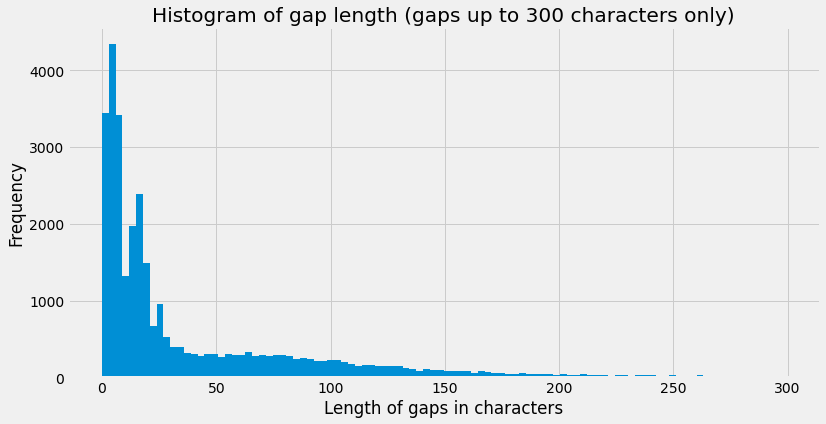

In [18]:
all_gaps = (train.gap_length[~train.gap_length.isna()]).append((train.gap_end_length[~train.gap_end_length.isna()]), ignore_index= True)
#filter outliers
all_gaps = all_gaps[all_gaps<300]
fig = plt.figure(figsize=(12,6))
all_gaps.plot.hist(bins=100)
plt.title("Histogram of gap length (gaps up to 300 characters only)")
plt.xticks(rotation=0)
plt.xlabel("Length of gaps in characters")
plt.show()

# Color printing essays including the gaps

I saw  a very pretty way to do this in the Notebook made by Sanskar Hasija (https://www.kaggle.com/odins0n/feedback-prize-eda). The code is nice but did not print the gaps yet. Below, I make a function that adds all gaps in an essay as rows with discourse type "Nothing".

In [19]:
def add_gap_rows(essay):
    cols_to_keep = ['discourse_start', 'discourse_end', 'discourse_type', 'gap_length', 'gap_end_length']
    df_essay = train.query('id == @essay')[cols_to_keep].reset_index(drop = True)

    #index new row
    insert_row = len(df_essay)
   
    for i in range(1, len(df_essay)):          
        if df_essay.loc[i,"gap_length"] >0:
            if i == 0:
                start = 0 #as there is no i-1 for first row
                end = df_essay.loc[0, 'discourse_start'] -1
                disc_type = "Nothing"
                gap_end = np.nan
                gap = np.nan
                df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
                insert_row += 1
            else:
                start = df_essay.loc[i-1, "discourse_end"] + 1
                end = df_essay.loc[i, 'discourse_start'] -1
                disc_type = "Nothing"
                gap_end = np.nan
                gap = np.nan
                df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
                insert_row += 1

    df_essay = df_essay.sort_values(by = "discourse_start").reset_index(drop=True)

    #add gap at end
    if df_essay.loc[(len(df_essay)-1),'gap_end_length'] > 0:
        start = df_essay.loc[(len(df_essay)-1), "discourse_end"] + 1
        end = start + df_essay.loc[(len(df_essay)-1), 'gap_end_length']
        disc_type = "Nothing"
        gap_end = np.nan
        gap = np.nan
        df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
        
    return(df_essay)

In [20]:
add_gap_rows("129497C3E0FC")

,discourse_start,discourse_end,discourse_type,gap_length,gap_end_length
0,0,57.0,Lead,NaN,NaN
1,58,111.0,Claim,NaN,NaN
2,112,120.0,Nothing,NaN,NaN
3,121,137.0,Claim,8.0,NaN
4,138,157.0,Nothing,NaN,NaN
5,158,281.0,Counterclaim,19.0,NaN
6,282,385.0,Nothing,NaN,NaN
7,386,443.0,Position,103.0,3173.0
8,444,3617.0,Nothing,NaN,NaN


This enables me to make a function that uses the code made by Sanskar Hasija to color print an essay. The code is nice but did not print the gaps yet.

In [21]:
def print_colored_essay(essay):
    df_essay = add_gap_rows(essay)
    #code from https://www.kaggle.com/odins0n/feedback-prize-eda, but adjusted to df_essay
    essay_file = "../input/feedback-prize-2021/train/" + essay + ".txt"

    ents = []
    for i, row in df_essay.iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })

    with open(essay_file, 'r') as file: data = file.read()

    doc2 = {
        "text": data,
        "ents": ents,
    }

    colors = {'Lead': '#EE11D0','Position': '#AB4DE1','Claim': '#1EDE71','Evidence': '#33FAFA','Counterclaim': '#4253C1','Concluding Statement': 'yellow','Rebuttal': 'red'}
    options = {"ents": df_essay.discourse_type.unique().tolist(), "colors": colors}
    spacy.displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True);

In [22]:
print_colored_essay("7330313ED3F0")
#print_colored_essay("423A1CA112E2")

# Most used words per Discourse Type
Now, I want to find out which words are used the most for each discourse_type (stopwords excluded). I have also taken out some extra words that were all over the place in the figures for each discourse_type. I am not sure how useful this is. A first thing that I notice is that "however," is used a lot in Rebuttal.

In [23]:
train['discourse_text'] = train['discourse_text'].str.lower()

#get stopwords from nltk library
stop_english = stopwords.words("english")
other_words_to_take_out = ['school', 'students', 'people', 'would', 'could', 'many']
stop_english.extend(other_words_to_take_out)

#put series of Top-10 words in dict for all discourse types
counts_dict = {}
for dt in train['discourse_type'].unique():
    df = train.query('discourse_type == @dt')
    text = df.discourse_text.apply(lambda x: x.split()).tolist()
    text = [item for elem in text for item in elem]
    df1 = pd.Series(text).value_counts().to_frame().reset_index()
    df1.columns = ['Word', 'Frequency']
    df1 = df1[~df1.Word.isin(stop_english)].head(10)
    df1 = df1.set_index("Word").sort_values(by = "Frequency", ascending = True) #to series
    counts_dict[dt] = df1


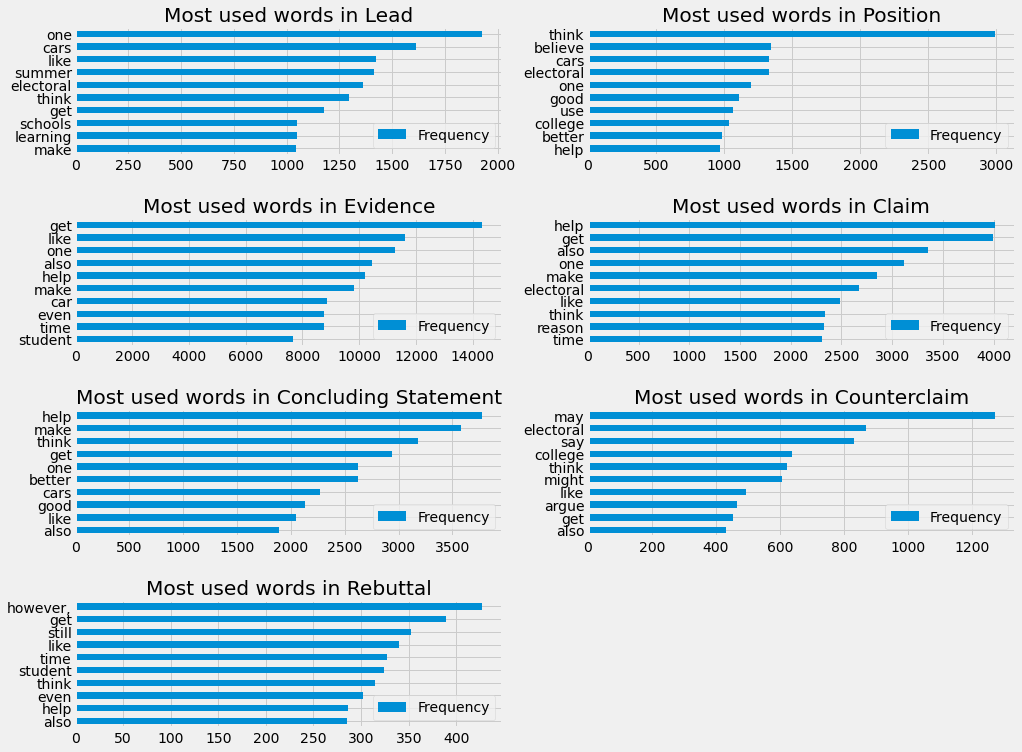

In [24]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

keys = list(counts_dict.keys())

for n, key in enumerate(keys):
    ax = plt.subplot(4, 2, n + 1)
    ax.set_title(f"Most used words in {key}")
    counts_dict[keys[n]].plot(ax=ax, kind = 'barh')
    plt.ylabel("")

**To be continued. Please stay tuned!**